In [1]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import maximum_filter
import os
import hashlib
import sounddevice as sd
import wavio
import ipywidgets as widgets
from IPython.display import display

## Učitavanje audio fajla

In [2]:
def load_audio(file_path, sr=16000):
    y, sr = librosa.load(file_path, sr=sr)
    return y, sr

## Pronalaženje peak-ova

In [3]:
def find_peaks(y, sr=16000, n_fft=2048, hop_length=512, neighborhood_size=30, threshold_min=-50, threshold_max=-20):
    S = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop_length))
    S_db = librosa.amplitude_to_db(S, ref=np.max)
    neighborhood = np.ones((neighborhood_size, neighborhood_size))
    local_max = maximum_filter(S_db, footprint=neighborhood) == S_db
    threshold_mask = (S_db >= threshold_min) & (S_db <= threshold_max)
    detected_peaks = local_max & threshold_mask
    peaks = np.argwhere(detected_peaks) 
    return peaks

## Prikaz spektrograma sa pronađenim peak-ovima

In [4]:
def plot_spectrogram_with_peaks(y, sr=16000, n_fft=2048, hop_length=512):
    S = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop_length))
    S_db = librosa.amplitude_to_db(S, ref=np.max)
    plt.figure(figsize=(14, 5))
    librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    
    peaks = find_peaks(y, sr, n_fft, hop_length)
    print("Peaks num: ", len(peaks))
    
    times = librosa.frames_to_time(peaks[:, 1], sr=sr)
    freqs = librosa.fft_frequencies(sr=sr)[peaks[:, 0]]
    
    plt.scatter(times, freqs, color='green', marker='o', s=15)
    plt.title("Spectrogram with Peaks")
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.show()

Peaks num:  607


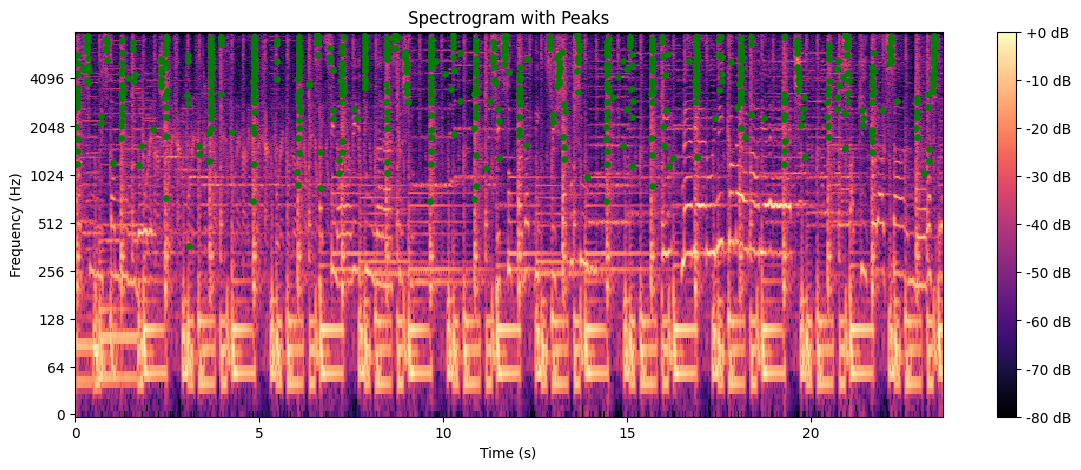

In [13]:
y, _ = load_audio('test.mp3')
plot_spectrogram_with_peaks(y)

## Generisanje fingerprint-a iz cijelog dataset-a i spremanje u dictionary

In [6]:
def generate_fingerprint(peaks, fan_value=15):
    fingerprint = []
    for i in range(len(peaks)):
        freq1, time1 = peaks[i]
        for j in range(1, fan_value):
            if (i + j) < len(peaks):
                freq2, time2 = peaks[i + j]
                delta_t = time2 - time1
                hash_input = f"{freq1}|{freq2}|{delta_t}"
                hash_value = hashlib.sha1(hash_input.encode('utf-8')).hexdigest()
                fingerprint.append(hash_value)
    return fingerprint

In [7]:
dataset_folder = "dataset2"
fingerprints = {}
for filename in os.listdir(dataset_folder):
    file_path = os.path.join(dataset_folder, filename)
    y, _ = load_audio(file_path)
    peaks = find_peaks(y)
    fingerprints[filename] = generate_fingerprint(peaks)

In [8]:
print(len(fingerprints))
print(len(fingerprints['Emina Jahovic - Lolo.mp3']))

100
74669


In [9]:
def index_fingerprints(fingerprints):
    hash_dict = defaultdict(list)
    for filename, file_fingerprints in fingerprints.items():
        for hash_value in file_fingerprints:
            hash_dict[hash_value].append(filename)
    return hash_dict

In [10]:
from collections import defaultdict
hash_dict = index_fingerprints(fingerprints)

## Matching audio uzorka tj. njegovog fingerprint-a sa ostatkom "baze"

In [11]:
def match_fingerprints(hash_dict, new_fingerprint):
    match_count = defaultdict(int)
    for hash_value in new_fingerprint:
        if hash_value in hash_dict:
            for filename in hash_dict[hash_value]:
                match_count[filename] += 1
    return match_count

In [12]:
import sounddevice as sd
import wavio
import ipywidgets as widgets

duration = 15
channels = 1
sample_rate = 16000

record_button = widgets.Button(description="Start Recording")
output = widgets.Output()

def record_audio(b):
    with output:
        output.clear_output()
        print("Recording...")
        recording = sd.rec(int(duration * sample_rate), samplerate=sample_rate, channels=channels, dtype='int16')
        sd.wait() 
        print("Recording finished.")
        
        wavio.write("recorded_audio.wav", recording, sample_rate, sampwidth=2)
        print("Audio saved as recorded_audio.wav")
        
        print("****************************************************")
        process_recording("recorded_audio.wav")

def process_recording(new_audio_path):
    y_new, _ = load_audio(new_audio_path)
    new_peaks = find_peaks(y_new)
    new_fingerprint = generate_fingerprint(new_peaks)
    
    match_count = match_fingerprints(hash_dict, new_fingerprint)
    sorted_match_count = sorted(match_count.items(), key=lambda x: x[1], reverse=True)

    for filename, count in sorted_match_count:
        print(f"{filename}: {count}")

record_button.on_click(record_audio)
display(record_button, output)

Button(description='Start Recording', style=ButtonStyle())

Output()